# Wstęp
Celem projektu było zapoznanie się z teorią __MACD__ oraz implemetacja owego wskaźnika, przy użyciu danych wejściowych, o długości 1000 próbek w formacie _.csv_. W przedstawionym sprawozdaniu wykorzystane są dane historyczne __WIG20__.  
Do wykonania zadania wykorzystałem język _Python_ oraz biblioteki _pandas_, _matplotlib_ oraz _numpy_.  

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Do wyznaczenia wskaźnika __MACD__ potrzebna była implementacja funkcji obliczającej wykładniczą średnią kroczącą (EMA) dla danych wejściowych z określoną liczbą okresów. Wykładnicza średnia krocząca dana jest wzorem: $${EMA}_N = \frac{p_0 + (1 - \alpha)p_1 + (1 - \alpha)^2p_2 + \dots + (1 - \alpha)^Np_N}{1 + (1 - \alpha) + (1 - \alpha)^2 + \dots + (1 - \alpha)^N}$$gdzie:
* $p_i$ jest próbką z i-tego dnia, $p_0$ jest próbką z aktualnego dnia, $p_N$ - to próbka sprzed
N dni
* $\alpha = \frac{2}{N + 1}$
* N - liczba okresów 

# Implementacja
Poniżej znajduje się moja implementacja wspomnianej funkcji. Przyjmuje ona za argument numer obecnego dnia, dla którego liczymy średnią; okres, czyli liczbę próbek branych pod uwagę oraz same badane próbki.  

Na wstępie do zmiennych lokalnych przypisuję wartości występujące przy każdym wywyłaniu funcji, tj. do licznika przypisuję wartość próbki w podanym dniu, do mianownika przypisuję 1 oraz tworzę zmienną pomocniczą z wartościa wyrażenia $1 - \alpha$.  

Następnie w pętli wykonującej się N razy zwiększam odpowiednio wartości licznika i mianownika, zgodnie ze wzorem na wykładniczą średnią kroczącą. Pomijam przypadki gdzie próbujemy odwołać się do próbki z dnia, dla którego nie mamy danych. Stąd jeżeli obecny dzień jest mniejszy niż okres, wynik będzie niedokładny.

In [16]:
def EMA(currentDay, period, samples):
    nominator = samples[currentDay]
    denominator = 1
    oneMinusAlpha = 1 - (2 / (period + 1))

    for i in range(1, period + 1):
        if currentDay - i < 0:
            continue
        tmp = pow(oneMinusAlpha, i)
        nominator += tmp * samples[currentDay - i]
        denominator += tmp

    return nominator / denominator

Poniższa funkcja zwraca wartość MACD, dla podanego dnia oraz danych wejściowych. Wartość obliczana jest przy pomocy wyrażenia:$$MACD = {EMA}_{12} - {EMA}_{26}$$

In [17]:
def MACD(currentDay, samples):
    return EMA(currentDay, 12, samples) - EMA(currentDay, 26, samples)

Aby przeprowadzić symulację użycia wskaźnika __MACD__ wczytałem historyczne dane giełdowe, w tym przypadku ceny zamknięcia __WIG20__ z okresu od 2 stycznia 2015 do 2 stycznia 2019, a następnie utworzyłem potrzebne zmienne do przechowywania obliczonych wartości MACD, SIGNAL oraz wartości bieżącego zysku/straty. Zgromadzone w tych strukturach dane wykorzystałem później do sporządzenia wykresów. Stworzyłem również zmienne z wartościami założonymi w treści zadania, tj. ilość próbek wynosi 1000, na starcie posiadamy 1000 akcji oraz 0 gotówki. Pozostałe zmiennie wykorzystuję w algorytmie decydującym o zakupie, bądź sprzedaży.

In [18]:
data = pd.read_csv("wig20.csv")
samples = data['Zamkniecie']
macd = []
signal = []
wallet = []
N = 1000
stock = 1000
cash = 0
diff = 0.0  # variable to store difference between MACD and SIGNAL
q = 300     # quantity of stock to buy/sell 
start = (stock * samples[0]) + cash  # value of the wallet at the beginning

Poniższa pętla N razy wyznacza wartości MACD oraz SIGNAL, czyli wykładniczej średniej kroczącej o
okresie 9, policzonej z MACD. Wartości zapisywane są w odpowiadających listach.

In [19]:
for j in range(0, N):
    macd.append(MACD(j, samples))
    signal.append(EMA(j, 9, macd))

## Algorytm decyzyjny
Stworzony przezemnie algorytm decydujący o zakupie, bądź sprzedaży, pomija pierwsze 26 próbek, z racji iż dane z tego okresu są niekompletne, stąd wartości MACD niedokładne.  

Przy każdym następnym obiegu pętli _while_ obliczana jest różnica między wartością MACD z tego dnia, a wartością SIGNAL. Pozwala to na przewidzenie, czy linie ich wykresów zmierzają ku przecięciu, a więc czy cena akcji zacznie maleć lub rosnąć. Przed podjęciem decyzji o transakcji sprawdzam również, czy wartość MACD z danego dnia jest większa równa 30 lub mniejsza równa -30, dzięki czemu ustalam czy zmiana ceny akcji była znacząca.  

Po spełnieniu warunków na "bliskość" wykresów oraz wartości MACD, sprawdzany jest znak wcześniej policzonej różnicy. Jeżeli różnica jest ujemna oznacza to, że wykres SIGNAL jest ponad wykresem MACD, a więc cena akcji spadła, stąd decyzja o zakupie, pod warunkiem posiadania wystarczającej ilości gotówki. W przeciwnym przypadku, gdy wykres MACD jest ponad SIGNAL oraz posiadana jest dana liczba akcji, następuje decyzja o sprzedaży.  

W przypadku dokonania decyzji o transakcji pętlą _for_ pomijam kilka następnych dni, aby uniknąć wykonania ponownej transakcji dla tej samej zmiany trendu. Przy każdym obiegu głównej pętli zapisywany jest obecny zysk/strata. Dane te posługują do późniejszego sporządzenia wykresu zysku/straty.

In [20]:
i = 0
while i < N:
    wallet.append(((((stock * samples[i]) + cash) - start) / start) * 100)
    if i < 27:  # begin transactions after first 26 days
        i += 1
        continue
    diff = macd[i] - signal[i]
    if abs(diff) < 0.6 and abs(macd[i]) >= 30:   # close to each other and big change
        if diff < 0 and cash >= q * samples[i]:  # SIGNAL above MACD -> buy
            cash -= q * samples[i]
            stock += q
        elif diff > 0 and stock >= q:  # MACD above SIGNAL -> sell
            cash += q * samples[i]
            stock -= q
        for j in range(0, 9):  # skipping few days to not duplicate transactions
            wallet.append(((((stock * samples[i]) + cash) - start) / start) * 100)
            i += 1
    i += 1

# Prezentacja danych
Poniżej zaprezentowane są trzy wykresy sporządzone na podstawie uzyskanych danych, na przestrzeni 1000 próbek.  
* Wykres zmiany wartości MACD oraz SIGNAL
* Wykres zmiany ceny zamknięcia WIG20
* Wykres zysku/straty wyrażonej w procentach

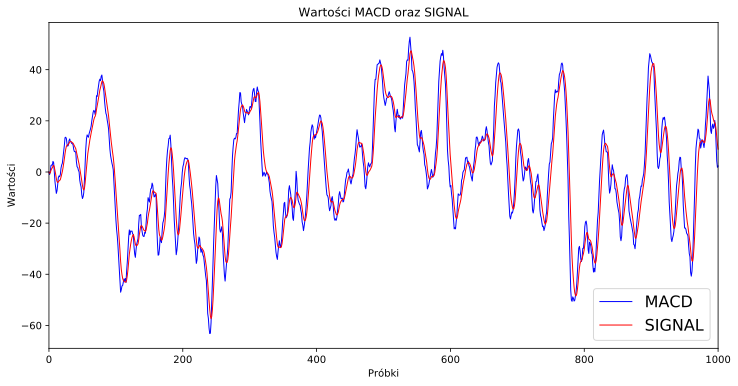

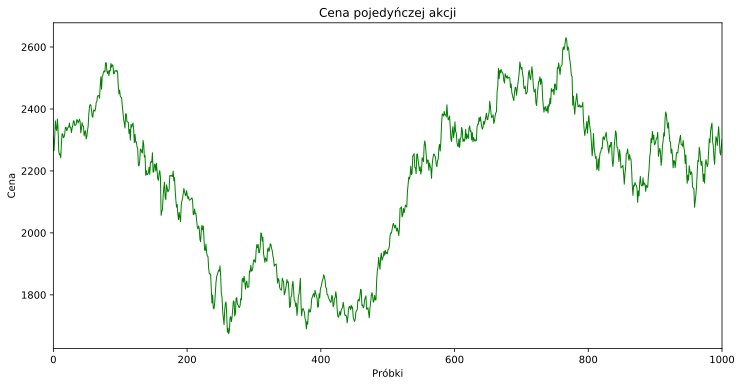

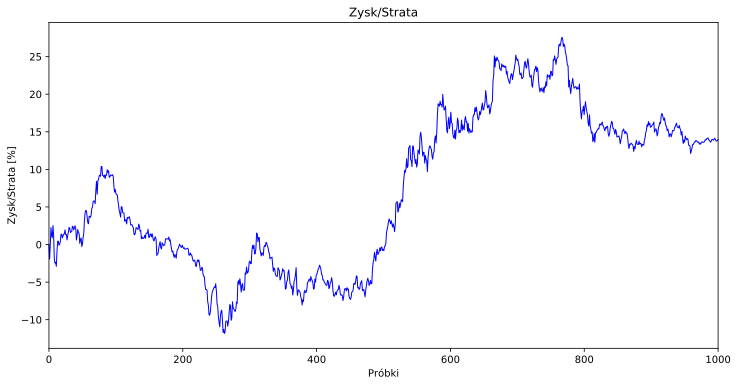

In [21]:
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('pdf', 'svg')
x = np.linspace(0, 1000, 1000)
plt.rcParams['figure.figsize'] = (12, 6)
plt.xlim(0, 1000)
plt.xlabel('Próbki')
plt.ylabel('Wartości')
plt.plot(x, macd, 'b-', label='MACD', linewidth=1.0)
plt.plot(x, signal, 'r-', label='SIGNAL', linewidth=1.0)
plt.legend(loc='best', fontsize=16)
plt.title('Wartości MACD oraz SIGNAL')
plt.show()
x = np.linspace(0, 1000, 1000)
plt.rcParams['figure.figsize'] = (12, 6)
plt.xlim(0, 1000)
plt.xlabel('Próbki')
plt.ylabel('Cena')
plt.plot(x, samples, 'g-', linewidth=1.0)
plt.title('Cena pojedyńczej akcji')
plt.show()
x = np.linspace(0, 1000, 1000)
plt.rcParams['figure.figsize'] = (12, 6)
plt.xlim(0, 1000)
plt.xlabel('Próbki')
plt.ylabel('Zysk/Strata [%]')
plt.plot(x, wallet, 'b-', linewidth=1.0)
plt.title('Zysk/Strata')
plt.show()

# Wnioski

Jak widać na wykresie zysku, na podstawie analizy zmiany wykresów MACD oraz SIGNAL udało mi się zarobić. Końcowy zysk wyniósł ok. 14%. Wynik jest jednak bardzo zależny od danych wejściowych, przykładowo dla innych sprawdzanych danych algorytm jedynie minimalizował straty, nie zarabiając.  

Wartości MACD i SIGNAL są bardzo czułe na jakiekolwiek zmiany ceny akcji oraz są opóźnione w stosunku do faktycznej zmiany. Biorąc to pod uwagę, należy dokonywać transakcji tylko gdy zmiana jest znacząca, stąd też podejmowanie decyzji na podstawie wskaźnika MACD ma sens jedynie przy inwestycjach długoterminowych, na krótki okres czasu metoda ta się nie sprawdzi.  

Uważam, że podejmowanie decyzji o sprzedaży bądź kupnie, jedynie na podstawie wskaźnika MACD nie jest wystarczające by osiągnąć pewne zyski. Na cenę akcji, jej zmianę wpływa bardzo dużo czynników, których zaprezentowana metoda nie bierze pod uwagę, stąd jest niepewna.